### Import necessary libraries

List of Required External Libraries

1. Scikit Learn
2. torch
3. torchmetrics
4. OpenCV
5. PIL
6. torchvision
7. Numpy
8. Pandas


In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
import torchvision.models as models
import torchmetrics
from torch.utils.data import random_split
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [33]:
seed = 1234

random.seed(seed)  # Python's built-in random module
np.random.seed(seed)  # NumPy
torch.manual_seed(seed)  # PyTorch CPU
torch.cuda.manual_seed(seed)  # PyTorch GPU (if available)
torch.cuda.manual_seed_all(seed)  # All GPUs (if using multi-GPU)


torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False  # Disabling can reduce performance but ensures reproducibility

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [35]:
calc_psnr = torchmetrics.image.PeakSignalNoiseRatio().to(device)
calc_ssim = torchmetrics.image.StructuralSimilarityIndexMeasure().to(device)

In [36]:
HR_img_dir = '/kaggle/input/gsoc25-sr2-dataset/Dataset/HR'
LR_img_dir = '/kaggle/input/gsoc25-sr2-dataset/Dataset/LR'

In [37]:
import os
import pandas as pd

def load_hr_lr_npy_to_dataframe(hr_dir, lr_dir):
    data = []

    # Get list of HR and LR .npy files
    hr_files = {file.split('_')[1].split('.')[0]: os.path.join(hr_dir, file) 
                for file in os.listdir(hr_dir) if file.startswith('HR_') and file.endswith('.npy')}
    
    lr_files = {file.split('_')[1].split('.')[0]: os.path.join(lr_dir, file) 
                for file in os.listdir(lr_dir) if file.startswith('LR_') and file.endswith('.npy')}

    # Find common indices in both HR and LR directories
    common_indices = set(hr_files.keys()) & set(lr_files.keys())

    for index in common_indices:
        data.append({'HR_image': hr_files[index], 'LR_image': lr_files[index]})

    return pd.DataFrame(data)

# Example usage:
common_df = load_hr_lr_npy_to_dataframe(HR_img_dir, LR_img_dir)
print(common_df.shape)


(300, 2)


In [38]:
np.load(common_df.iloc[0]["LR_image"]).shape

(1, 64, 64)

(-0.5, 63.5, 63.5, -0.5)

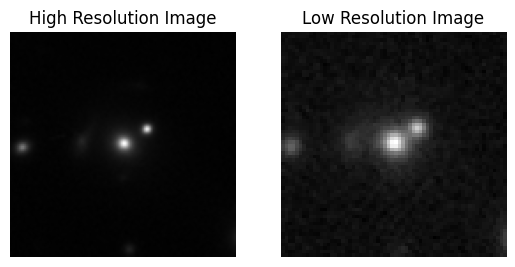

In [39]:
fig, axes = plt.subplots(nrows=1, ncols=2)

axes[0].imshow(np.load(common_df.iloc[0]["HR_image"])[0], cmap="gray")
axes[0].set_title("High Resolution Image")
axes[0].axis("off")
# plt.show()
axes[1].imshow(np.load(common_df.iloc[0]["LR_image"])[0], cmap="gray")
axes[1].set_title("Low Resolution Image")
axes[1].axis("off")

### Loading pretrained model from Task 3A for fine-tuning

In [40]:
class ResConv(nn.Module):
    def __init__(self, in_ch, out_ch, kernel, padding, stride, act="lrlu"):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=kernel, padding=padding, stride=stride)
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=kernel, padding=padding, stride=stride)
        
        self.res = nn.Conv2d(in_ch, out_ch, kernel_size=1)
        
        self.lrlu = nn.LeakyReLU(0.05, inplace=True)
        self.act = act

    def forward(self, x):
        skip = self.res(x)
        conv1 = self.lrlu(self.conv1(x))
        conv2 = self.conv2(conv1)

        if self.act == "lrlu":
            return self.lrlu(conv2 + skip)

        return conv2 + skip
        

In [41]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.resconv1 = ResConv(1, 128, kernel=3, padding=1, act="lrlu", stride=1)
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor=2)
        self.out_conv = nn.Conv2d(32, 1, kernel_size=3, padding=1, stride=1)
        
        self.lrlu = nn.LeakyReLU(0.05, inplace=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.resconv1(x)
        x = self.pixel_shuffle(x)
        x = self.out_conv(x)
        return self.sigmoid(x)

In [42]:
class Critic(nn.Module):
    def __init__(self):
        super().__init__()
        self.critic = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1),
            nn.LeakyReLU(0.05, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.LeakyReLU(0.05, inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2),
            nn.LeakyReLU(0.05, inplace=True),

            nn.Conv2d(256, 256, kernel_size=4, stride=2),
            nn.LeakyReLU(0.05, inplace=True),

            nn.Conv2d(256, 512, kernel_size=4, stride=2),
            nn.LeakyReLU(0.05, inplace=True),

            nn.Conv2d(512, 512, kernel_size=4, stride=2),
            nn.LeakyReLU(0.05, inplace=True),
        )
        self.mlp = nn.Linear(2048, 1)

    def forward(self, x):
        features = self.critic(x)
        return self.mlp(features.flatten(start_dim=1))


In [100]:
generator_model_path = "/kaggle/input/gsoc25_task_3a_models/pytorch/default/1/gsoc25_sr_task1_generator_model_FINAL.pth"
critic_model_path = "/kaggle/input/gsoc25_task_3a_models/pytorch/default/1/gsoc25_sr_task1_critic_model_FINAL.pth"

In [119]:
generator = torch.load(generator_model_path)
critic = torch.load(critic_model_path)

<ipython-input-119-4289f2bcc679>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator = torch.load(generator_model_path)
<ipython-input-119-4289f2bcc679>:2: FutureWarn

In [120]:
if torch.cuda.device_count() < 2:
    generator = torch.load(generator_model_path, map_location="cuda:0")  # Use "cpu" if loading on CPU
    critic = torch.load(critic_model_path, map_location="cuda:0")  # Use "cpu" if loading on CPU

    # Remove DataParallel wrapper if it exists
    if isinstance(generator, torch.nn.DataParallel) or isinstance(critic, torch.nn.DataParallel):
        generator = generator.module  # Extract the actual model
        critic = critic.module  # Extract the actual model

if not torch.cuda.is_available():
    generator = torch.load(generator_model_path, map_location="cpu")  # Use "cpu" if loading on CPU
    critic = torch.load(critic_model_path, map_location="cpu")  # Use "cpu" if loading on CPU

    # Remove DataParallel wrapper if it exists
    if isinstance(generator, torch.nn.DataParallel) or isinstance(critic, torch.nn.DataParallel):
        generator = generator.module  # Extract the actual model
        critic = critic.module  # Extract the actual model

<ipython-input-120-8ead464096b7>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator = torch.load(generator_model_path, map_location="cuda:0")  # Use "cpu" if loading

In [121]:
generator

Generator(
  (resconv1): ResConv(
    (conv1): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (res): Conv2d(1, 128, kernel_size=(1, 1), stride=(1, 1))
    (lrlu): LeakyReLU(negative_slope=0.05, inplace=True)
  )
  (pixel_shuffle): PixelShuffle(upscale_factor=2)
  (out_conv): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (lrlu): LeakyReLU(negative_slope=0.05, inplace=True)
  (sigmoid): Sigmoid()
)

In [122]:
"Generator", generator(torch.randn(1, 1, 64, 64).to(device).float()).shape, "Critic", critic(torch.randn(1, 1, 128, 128).to(device).float()).shape

('Generator', torch.Size([1, 1, 128, 128]), 'Critic', torch.Size([1, 1]))

In [123]:
train_df, test_df = train_test_split(common_df, test_size=0.1, random_state=42, shuffle=True)
train_df.shape, test_df.shape

((270, 2), (30, 2))

In [124]:
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42, shuffle=True)
train_df.shape, val_df.shape

((243, 2), (27, 2))

In [125]:
class GravLenseImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        hr_image = np.squeeze(np.load(self.dataframe.iloc[idx]["HR_image"]).astype(np.float32))
        lr_image = np.squeeze(np.load(self.dataframe.iloc[idx]["LR_image"]).astype(np.float32))
        
        hr_image = torch.tensor(hr_image).unsqueeze(0)
        lr_image = torch.tensor(lr_image).unsqueeze(0)


        return hr_image, lr_image

In [126]:
train_dataset = GravLenseImageDataset(train_df)
test_dataset = GravLenseImageDataset(test_df)
val_dataset = GravLenseImageDataset(val_df)

In [127]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, drop_last=False, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, drop_last=False, num_workers=2)

In [128]:
def gradient_penalty(critic, real, fake, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    alpha = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * alpha + fake * (1 - alpha)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty


In [129]:
CRITIC_ITR = 5
LAMBDA = 8
ALPHA = 0.4
EPOCHS = 12

In [130]:
optim_gen = torch.optim.Adam(generator.parameters(), lr=2e-4, betas=(0.9, 0.99))
optim_critic = torch.optim.Adam(critic.parameters(), lr=3e-4, betas=(0.0, 0.9))

In [131]:
from tqdm import tqdm

### Training, Validation and Test Functions

In [132]:
def val():
    generator.eval()
    critic.eval()
    batches = len(val_dataloader)

    gen_loss = 0
    cri_loss = 0
    wasserstein_distance = 0
    mse_loss = 0
    psnr = 0
    ssim = 0
    perp_loss = 0
    for i, batch in enumerate(val_dataloader):
        hr_images, lr_images = batch
        lr_images = lr_images.to(device).float()
        hr_images = hr_images.to(device).float()

        gen_hr_image = generator(lr_images)

        gen_score = critic(gen_hr_image.detach()).mean()
        actual_score = critic(hr_images).mean()

        wasserstein_distance = actual_score - gen_score
        gp = gradient_penalty(critic, hr_images, gen_hr_image, device=device)
        critic_loss = -wasserstein_distance + LAMBDA * gp

        mse = F.mse_loss(gen_hr_image, hr_images)

            
        generator_loss = -0.07*gen_score + 0.2*mse 

        gen_loss += generator_loss.item()
        cri_loss += critic_loss.item()
        wasserstein_distance += wasserstein_distance.item()
        mse_loss += mse.item()

        calc_psnr.update(gen_hr_image, hr_images)
        calc_ssim.update(gen_hr_image, hr_images)

    print(f"Validation:")
    print(f">> Gen Loss: {(gen_loss/batches):.4f} | Cri Loss: {(cri_loss/batches):.4f} | PSNR: {(calc_psnr.compute().cpu()):.4f} | SSIM: {(calc_ssim.compute().cpu()):.4f} | MSE: {(mse_loss/batches):.4f}\n")
    calc_psnr.reset()
    calc_ssim.reset()



In [133]:
def test():
    generator.eval()
    critic.eval()
    batches = len(test_dataloader)

    gen_loss = 0
    cri_loss = 0
    wasserstein_distance = 0
    mse_loss = 0
    psnr = 0
    ssim = 0
    perp_loss = 0
    for i, batch in enumerate(test_dataloader):
        hr_images, lr_images = batch
        lr_images = lr_images.to(device).float()
        hr_images = hr_images.to(device).float()

        gen_hr_image = generator(lr_images)

        gen_score = critic(gen_hr_image.detach()).mean()
        actual_score = critic(hr_images).mean()

        wasserstein_distance = actual_score - gen_score
        gp = gradient_penalty(critic, hr_images, gen_hr_image, device=device)
        critic_loss = -wasserstein_distance + LAMBDA * gp

        mse = F.mse_loss(gen_hr_image, hr_images)

            
        generator_loss = -0.07*gen_score + 0.2*mse 

        gen_loss += generator_loss.item()
        cri_loss += critic_loss.item()
        wasserstein_distance += wasserstein_distance.item()
        mse_loss += mse.item()

        calc_psnr.update(gen_hr_image, hr_images)
        calc_ssim.update(gen_hr_image, hr_images)


    print(f"Gen Loss: {(gen_loss/batches):.4f} | Cri Loss: {(cri_loss/batches):.4f} | PSNR: {(calc_psnr.compute().cpu()):.4f} | SSIM: {(calc_ssim.compute().cpu()):.4f} | MSE: {(mse_loss/batches):.4f}\n")
    calc_psnr.reset()
    calc_ssim.reset()



In [134]:
def train():
    generator.train()
    critic.train()
    batches = len(train_dataloader)
    for epoch in range(EPOCHS):
        progress_bar = tqdm(train_dataloader, desc=f"Epoch [{epoch+1}/{EPOCHS}]", leave=True)

        gen_loss = 0
        cri_loss = 0
        wasserstein_distance = 0
        mse_loss = 0
        psnr = 0
        ssim = 0
        for i, batch in enumerate(progress_bar):
            hr_images, lr_images = batch
            lr_images = lr_images.to(device).float()
            hr_images = hr_images.to(device).float()

            generator.eval()
            critic.train()

            for _ in range(CRITIC_ITR):
                
                fake = generator(lr_images)

                real_score = critic(hr_images)
                fake_score = critic(fake.detach())

                gp = gradient_penalty(critic, hr_images, fake, device=device)

                wasserstein_distance = real_score.mean() - fake_score.mean()

                critic_loss = -wasserstein_distance + LAMBDA * gp

                optim_critic.zero_grad()
                critic_loss.backward()
                optim_critic.step()

            generator.train()
            critic.eval()

            gen_hr_image = generator(lr_images)
                
            
            gen_score = critic(gen_hr_image.detach()).mean()
            actual_score = critic(hr_images).mean()

            wasserstein_distance = actual_score - gen_score
            gp = gradient_penalty(critic, hr_images, gen_hr_image, device=device)
            critic_loss = -wasserstein_distance + LAMBDA * gp

            mse = F.mse_loss(gen_hr_image, hr_images)

        
            generator_loss = -0.07*gen_score + 0.2*mse     

            gen_loss += generator_loss.item()
            cri_loss += critic_loss.item()
            wasserstein_distance += wasserstein_distance.item()
            mse_loss += mse.item()

            calc_psnr.update(gen_hr_image, hr_images)
            calc_ssim.update(gen_hr_image, hr_images)

            optim_gen.zero_grad()
            generator_loss.backward()
            optim_gen.step()

        progress_bar.set_postfix(D_loss=critic_loss.item(), G_loss=generator_loss.item(), PSNR=calc_psnr.compute().cpu(), SSIM=calc_ssim.compute().cpu(), MSE=mse_loss/batches)
        print(f"Training:")
        print(f"Gen Loss: {(gen_loss/batches):.4f} | Cri Loss: {(cri_loss/batches):.4f} | PSNR: {(calc_psnr.compute().cpu()):.4f} | SSIM: {(calc_ssim.compute().cpu()):.4f} | MSE: {(mse_loss/batches):.4f}")
        calc_psnr.reset()
        calc_ssim.reset()
        progress_bar.close()

        val()



In [135]:
train()

Epoch [1/12]: 100%|██████████| 15/15 [00:31<00:00,  2.08s/it]

Training:
Gen Loss: -7.6903 | Cri Loss: -4.9222 | PSNR: 24.4917 | SSIM: 0.6718 | MSE: 0.0048


Validation:
>> Gen Loss: -103.1880 | Cri Loss: -0.3893 | PSNR: 29.2106 | SSIM: 0.7403 | MSE: 0.0014



Epoch [2/12]: 100%|██████████| 15/15 [00:31<00:00,  2.08s/it]

Training:
Gen Loss: -107.3948 | Cri Loss: -1.6015 | PSNR: 28.7880 | SSIM: 0.7629 | MSE: 0.0018


Validation:
>> Gen Loss: -133.0992 | Cri Loss: -1.9957 | PSNR: 28.8616 | SSIM: 0.6749 | MSE: 0.0016



Epoch [3/12]: 100%|██████████| 15/15 [00:31<00:00,  2.08s/it]

Training:
Gen Loss: -57.3089 | Cri Loss: -1.9498 | PSNR: 28.9356 | SSIM: 0.7260 | MSE: 0.0017


Validation:
>> Gen Loss: -10.8253 | Cri Loss: -2.5870 | PSNR: 28.4251 | SSIM: 0.6669 | MSE: 0.0018



Epoch [4/12]: 100%|██████████| 15/15 [00:31<00:00,  2.08s/it]

Training:
Gen Loss: -26.8939 | Cri Loss: -2.1313 | PSNR: 28.9995 | SSIM: 0.7402 | MSE: 0.0017


Validation:
>> Gen Loss: -24.1423 | Cri Loss: -2.9871 | PSNR: 28.6690 | SSIM: 0.6918 | MSE: 0.0017



Epoch [5/12]: 100%|██████████| 15/15 [00:31<00:00,  2.08s/it]

Training:
Gen Loss: 22.0301 | Cri Loss: -1.8672 | PSNR: 29.1207 | SSIM: 0.7632 | MSE: 0.0016


Validation:
>> Gen Loss: 53.5826 | Cri Loss: -2.6998 | PSNR: 28.9243 | SSIM: 0.7180 | MSE: 0.0016



Epoch [6/12]: 100%|██████████| 15/15 [00:31<00:00,  2.08s/it]

Training:
Gen Loss: 29.8209 | Cri Loss: -1.8349 | PSNR: 30.3446 | SSIM: 0.7862 | MSE: 0.0012


Validation:
>> Gen Loss: 164.5464 | Cri Loss: 0.8270 | PSNR: 29.1928 | SSIM: 0.7422 | MSE: 0.0015



Epoch [7/12]: 100%|██████████| 15/15 [00:31<00:00,  2.08s/it]

Training:
Gen Loss: -16.5719 | Cri Loss: -1.9180 | PSNR: 29.1844 | SSIM: 0.7930 | MSE: 0.0016


Validation:
>> Gen Loss: -132.4749 | Cri Loss: -2.5041 | PSNR: 29.1270 | SSIM: 0.7465 | MSE: 0.0015



Epoch [8/12]: 100%|██████████| 15/15 [00:31<00:00,  2.08s/it]

Training:
Gen Loss: -19.8315 | Cri Loss: -1.9993 | PSNR: 29.1713 | SSIM: 0.7992 | MSE: 0.0016


Validation:
>> Gen Loss: 29.1752 | Cri Loss: -2.2928 | PSNR: 29.0054 | SSIM: 0.7545 | MSE: 0.0016



Epoch [9/12]: 100%|██████████| 15/15 [00:31<00:00,  2.08s/it]

Training:
Gen Loss: -14.9363 | Cri Loss: -1.9404 | PSNR: 29.3169 | SSIM: 0.8063 | MSE: 0.0016


Validation:
>> Gen Loss: 0.4360 | Cri Loss: -1.9258 | PSNR: 29.1841 | SSIM: 0.7639 | MSE: 0.0015



Epoch [10/12]: 100%|██████████| 15/15 [00:31<00:00,  2.08s/it]

Training:
Gen Loss: -12.9170 | Cri Loss: -1.9803 | PSNR: 29.3093 | SSIM: 0.8092 | MSE: 0.0016


Validation:
>> Gen Loss: 14.0451 | Cri Loss: -2.0788 | PSNR: 29.1320 | SSIM: 0.7674 | MSE: 0.0015



Epoch [11/12]: 100%|██████████| 15/15 [00:31<00:00,  2.08s/it]

Training:
Gen Loss: -10.4436 | Cri Loss: -1.9408 | PSNR: 29.2936 | SSIM: 0.8127 | MSE: 0.0016


Validation:
>> Gen Loss: 35.5406 | Cri Loss: -1.9524 | PSNR: 29.4047 | SSIM: 0.7765 | MSE: 0.0014



Epoch [12/12]: 100%|██████████| 15/15 [00:31<00:00,  2.08s/it]

Training:
Gen Loss: 3.0696 | Cri Loss: -1.9769 | PSNR: 29.3098 | SSIM: 0.8150 | MSE: 0.0016


Validation:
>> Gen Loss: -14.6992 | Cri Loss: -2.3561 | PSNR: 29.1618 | SSIM: 0.7750 | MSE: 0.0015



In [137]:
test()

Gen Loss: -14.7099 | Cri Loss: -2.1863 | PSNR: 31.3010 | SSIM: 0.8537 | MSE: 0.0008



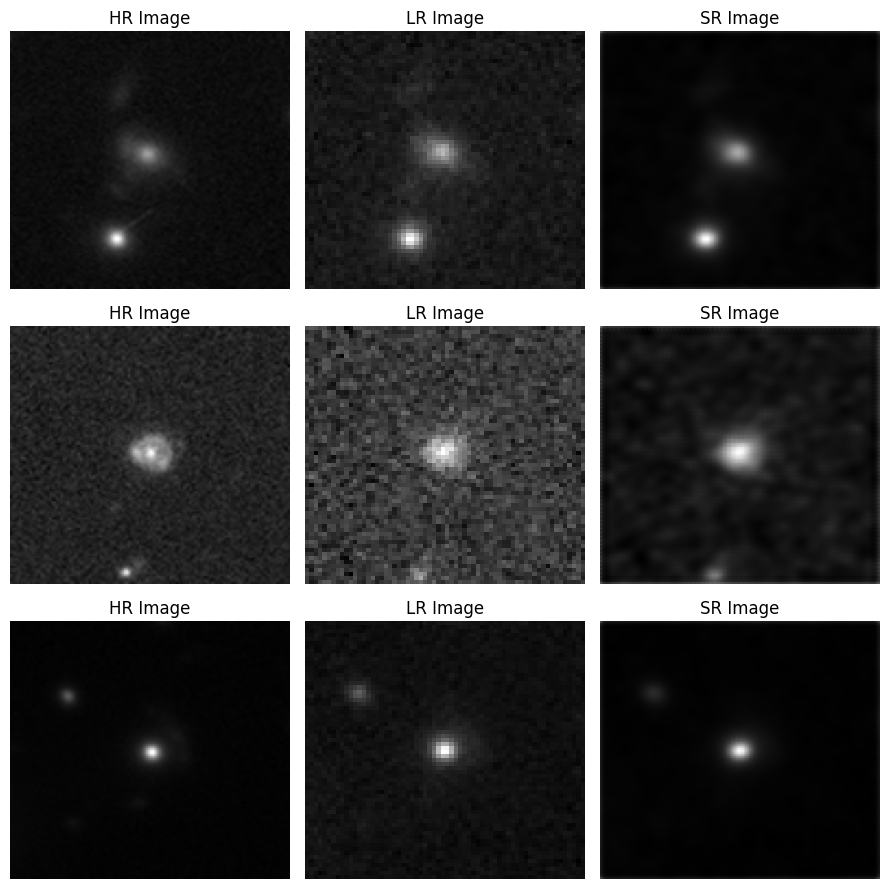

In [146]:
fig, axes = plt.subplots(3, 3, figsize=(9, 9))

for i in range(3):
    hr_image = torch.tensor(np.load(test_df.iloc[i+12]["HR_image"])).cpu().float().squeeze(0)
    lr_image = torch.tensor(np.load(test_df.iloc[i+12]["LR_image"])).cuda().float().unsqueeze(0)
    
    generator.eval()
    with torch.no_grad():
        sr_image = generator(lr_image).cpu().squeeze(0).numpy()
    
    
    axes[i, 0].imshow(hr_image, cmap='gray', aspect='auto')
    axes[i, 0].set_title("HR Image")
    axes[i, 0].axis("off")
    
    axes[i, 1].imshow(lr_image.cpu().numpy().reshape(64,64), cmap='gray', aspect='auto')
    axes[i, 1].set_title("LR Image")
    axes[i, 1].axis("off")
        
    axes[i, 2].imshow(sr_image.reshape(128,128), cmap='gray', aspect='auto')
    axes[i, 2].set_title("SR Image")
    axes[i, 2].axis("off")
        
plt.tight_layout()
plt.show()

In [32]:
torch.save(generator, "generator_gsoc25_sr_task_3B.pth")
torch.save(critic, "critic_gsoc25_sr_task_3B.pth")